# Neural-Net Training 

In [1]:
# import ipdb
# from tqdm import tqdm
# import os
import numpy as np
# import argparse
# import random
from PIL import Image
# from torch.utils.data import DataLoader
from PIL import Image, ImageDraw

from dataset import Balls_CF_Detection
from dataset_det import COLORS

def show_img(np_array_uint8, out_fn):
    if len(np_array_uint8.shape) == 3:
        img = Image.fromarray(np_array_uint8, 'RGB')
    elif len(np_array_uint8.shape) == 2:
        img = Image.fromarray(np_array_uint8)
    else:
        raise NameError('Unknown data type to show.')

    img.save(out_fn)
    img.show()


def show_bboxes(rgb_array, np_bbox, list_colors, out_fn='./bboxes_on_rgb.png'):
  """ Show the bounding box on a RGB image
  rgb_array: a np.array of shape (H,W,3) - it represents the rgb frame in uint8 type
  np_bbox: np.array of shape (9,4) and a bbox is of type [x1,y1,x2,y2]
  list_colors: list of string of length 9
  """
  assert np_bbox.shape[0] == len(list_colors)
  r=rgb_array.numpy()
  r = np.uint8(r)
  r = np.transpose(r, (1,2,0))

  img_rgb = Image.fromarray(r, 'RGB')
  draw = ImageDraw.Draw(img_rgb)
  N = np_bbox.shape[0]
  for i in range(N):
    color = COLORS[i]
    x_1, y_1, x_2, y_2 = np_bbox[i]
    draw.rectangle(((x_1, y_1), (x_2, y_2)), outline=color, fill=None)

  img_rgb.show()
  img_rgb.save(out_fn)

In [2]:
dataset = Balls_CF_Detection("data/train/train/")

#70 % -> training set
#10 % -> cross-validation => fine-tuning

# because we don't have that many images, we will use 80% for the training set and 20% for the validation set
# 20 % -> validation set

# parameters: size of minibatch (training), dropout, adam 

# Get a single image from the dataset and display it

#for i in range(10):    
#  img,p,pose = dataset[i]
#  print (img.shape)
#  print (pose.shape)
#  show_bboxes(img, pose, COLORS, out_fn='_x.png')

## Exercice 1

A predicted bounding box is considered correct if it overlaps more than 70% with a ground-truth bounding box, otherwise the bounding box is considered a false positive detection. Multiple detections are penalized. If a system predicts several bounding boxes that overlap with a single ground-truth bounding box, only one prediction is considered correct, the others are considered false positives.


IoU = Area of Overlap / Area of Union

Bounding box: (x,y,width,height) => (x,y) with predefined width & height

https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation

### RESNET

RES NET-18

* transfer learning: pre-trained RESNET
* without transfer learning 

RES NET -> good performance on IMAGE NET
=> compare the performance on our dataset

<b>In practice, very few people train an entire Convolutional Network
from scratch (with random initialization), because it is relatively
rare to have a dataset of sufficient size. Instead, it is common to
pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
contains 1.2 million images with 1000 categories), and then use the
ConvNet either as an initialization or a fixed feature extractor for
the task of interest.</b>

In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [30]:
# Data augmentation and normalization for training
# Just normalization for validation

# mean = 97.2231 ; std = 46.4774

data_transform = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


dset = Balls_CF_Detection("data/train/train/", data_transform["train"])
dval = Balls_CF_Detection("data/train/val/", data_transform["val"])

image_datasets = { "train": dset, "val": dval }

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = COLORS

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [31]:
# Compute mean & std.
# loader = torch.utils.data.DataLoader(dset, batch_size=len(dset), num_workers=1)
# data = next(iter(loader))

# print(data[0].mean())
# print(data[0].std())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


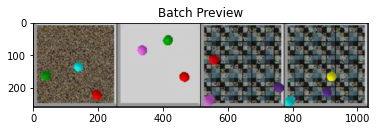

In [32]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    inp = std * inp + mean
    
    inp = inp/255
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
n = next(iter(dataloaders['train']))
inputs = n[0]
classes = n[1]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title="Batch Preview")

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                _, preds = torch.topk(outputs,3, 1)
                _, labels_data = torch.topk(labels,3, 1)
                
                # statistics
                running_loss += loss.item() * inputs.size(0)

                for i in range(0,inputs.size(0)): 
                    r=torch.unique(torch.cat((preds[i], labels_data[i]), 0))
                    running_corrects += ((6-len(r))/2)/3.0
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [24]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features

# Here the size of each output sample is set to 9.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_conv.fc = nn.Linear(num_ftrs, 9)
model_conv = model_conv.to(device)

criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()

# Observe that all parameters are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [14]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

NameError: name 'criterion' is not defined

In [113]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    error = 0
    total = 0
    #fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)

            outputs = model(inputs).cpu()
            
            outputs = np.array(outputs)
            outputs = np.where(outputs>=0.5, 1, 0)
              
            for j in range(inputs.size()[0]):
                images_so_far += 1
                
                err = abs(np.array(labels - outputs))
                
                error += sum(err[0])
                total += 9
                
                #ax = plt.subplot(num_images//2, 2, images_so_far)
                #ax.axis('off')
                
                #disp_predicted = ""
                
                #for ind in preds[j]:
                #    disp_predicted += COLORS[ind]+ ", "
                
                #ax.set_title('predicted: {}'.format(disp_predicted))
                #imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    print("Accuracy = ")
                    print((total-error)/total)
                    return            
                
        model.train(mode=was_training)

In [114]:
model_conv = torch.load("model_trained")
model_conv.eval()

visualize_model(model_conv, 2000)

Accuracy = 
0.8835555555555555


In [115]:
#torch.save(model_conv, "model_trained")
